# 03 — Feature Engineering

## Purpose
Prepare the cleaned weekly time series for modeling by creating lag-based, rolling-window, and calendar features.

## Objectives
1. Generate lag features to capture temporal dependencies.  
2. Create rolling statistics (mean, std) to encode local trends and volatility.  
3. Add calendar features (week, month, quarter) to capture seasonal patterns.  
4. Export a processed dataset under `data/processed/` for model training.

## Expected Outcome
A structured feature matrix containing original series and engineered features, ready for downstream modeling and validation.


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load cleaned dataset
path = "../data/raw/pharma_sales.csv"
df = pd.read_csv(path)
df["datum"] = pd.to_datetime(df["datum"])
df = df.set_index("datum").sort_index()

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Shape: (302, 8)

Columns: ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


## 1. Lag Features

Lag features capture temporal dependencies by including previous weeks' sales as predictors.  
For example, `lag1` represents last week's sales, `lag4` represents sales from four weeks ago, etc.


In [4]:
# Define lags in weeks
lags = [1, 2, 3, 4, 8, 12]

# Create lag features for each base variable
for col in df.columns:
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

print("Shape after adding lag features:", df.shape)
df.head()

Shape after adding lag features: (302, 56)


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,M01AB_lag1,M01AB_lag2,...,R03_lag3,R03_lag4,R03_lag8,R03_lag12,R06_lag1,R06_lag2,R06_lag3,R06_lag4,R06_lag8,R06_lag12
datum,,,,,,,,,,,,,,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2,14.00,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0,29.33,14.00,...,NaN,NaN,NaN,NaN,7.2,7.0,NaN,NaN,NaN,NaN
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0,30.67,29.33,...,32.0,NaN,NaN,NaN,12.0,7.2,7.0,NaN,NaN,NaN
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0,34.00,30.67,...,21.0,32.0,NaN,NaN,10.0,12.0,7.2,7.0,NaN,NaN


In [6]:
print("Total missing values:", df.isna().sum().sum())
print("Max missing in a single column:", df.isna().sum().max())

Total missing values: 240
Max missing in a single column: 12


In [7]:
df = df.dropna().copy()
print("Shape after dropping NaNs:", df.shape)
print("Remaining missing values:", df.isna().sum().sum())

Shape after dropping NaNs: (290, 56)
Remaining missing values: 0


### Lag Feature Overview

Each lag column represents sales shifted backward by N weeks, allowing the model to learn temporal dependencies.  
The plot below illustrates how the lagged version of one variable (e.g., N02BE) follows the original pattern with delay.


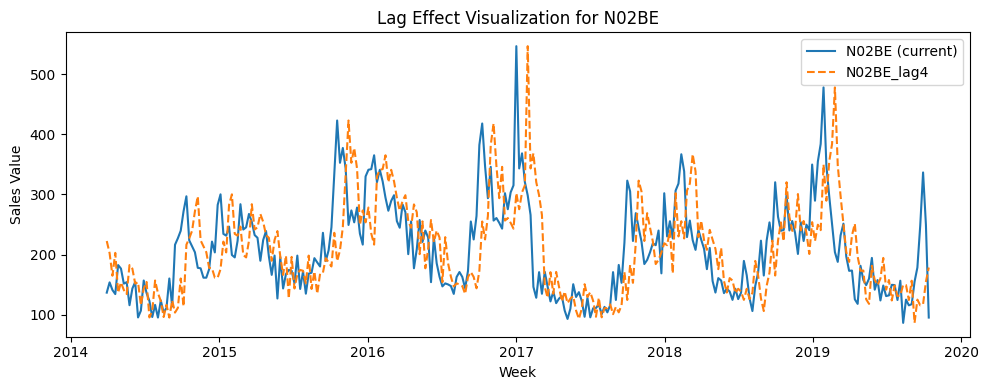

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df["N02BE"], label="N02BE (current)")
plt.plot(df["N02BE_lag4"], label="N02BE_lag4", linestyle="--")
plt.title("Lag Effect Visualization for N02BE")
plt.xlabel("Week")
plt.ylabel("Sales Value")
plt.legend()
plt.tight_layout()
plt.show()

**Observation**

The lagged series follows the same pattern as the original but shifted by four weeks.  
This confirms that lag features effectively encode temporal structure in the data.


## 2. Rolling Window Statistics

Rolling features capture local trends and variability by summarizing recent history.  
They provide smoother context for weekly fluctuations.


In [8]:
# Define rolling window sizes (in weeks)
windows = [4, 8, 12]  # ~1, 2, and 3 months

# Compute rolling mean and std for each base variable
for col in ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]:
    for w in windows:
        df[f"{col}_rollmean{w}"] = df[col].rolling(window=w).mean()
        df[f"{col}_rollstd{w}"] = df[col].rolling(window=w).std()

print("Shape after adding rolling features:", df.shape)
df.tail()

Shape after adding rolling features: (290, 104)


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,M01AB_lag1,M01AB_lag2,...,R03_rollmean8,R03_rollstd8,R03_rollmean12,R03_rollstd12,R06_rollmean4,R06_rollstd4,R06_rollmean8,R06_rollstd8,R06_rollmean12,R06_rollstd12
datum,,,,,,,,,,,,,,,,,,,,,
2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50,40.71,30.36,...,32.875000,17.175044,28.166667,15.706590,26.6500,4.330897,23.46250,4.612077,24.375000,4.333406
2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00,35.51,40.71,...,32.375000,17.328239,28.000000,15.719126,26.7750,4.095017,23.78750,4.284336,23.875000,4.349112
2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10,46.84,35.51,...,31.427083,16.540921,29.951389,15.682876,25.7750,4.461222,24.21250,3.978671,23.400000,4.064257
2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13,34.01,46.84,...,26.927083,8.943988,31.201389,14.964160,21.6825,7.560284,23.22875,5.748395,22.660833,5.190870
2019-10-13,7.67,6.237,3.50,95.100,26.0,2.0,12.000000,1.00,38.70,34.01,...,24.052083,9.647244,30.951389,15.281139,14.3075,10.065265,20.47875,9.745866,20.410833,7.841217


### Rolling Window Visualization

To verify the smoothing behavior of rolling statistics, we can visualize one series with its 4-week rolling mean.


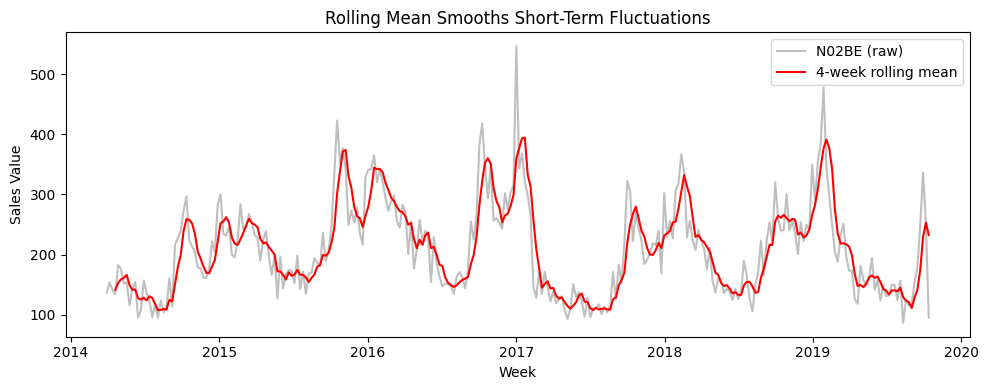

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(df["N02BE"], color="gray", alpha=0.5, label="N02BE (raw)")
plt.plot(df["N02BE_rollmean4"], color="red", label="4-week rolling mean")
plt.title("Rolling Mean Smooths Short-Term Fluctuations")
plt.xlabel("Week")
plt.ylabel("Sales Value")
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation**

The rolling mean reduces short-term noise and highlights the underlying trend.  
Such smoothed features help the model generalize and detect gradual changes rather than weekly spikes.


## 3. Calendar (Date-Derived) Features

Calendar features represent temporal context — such as month, quarter, or year boundaries —  
that may correlate with recurring sales patterns.  
They help the model capture seasonality or annual cycles more effectively.


In [13]:
# Calendar-based feature extraction (version-safe)
df["year"] = df.index.year
df["month"] = df.index.month
df["quarter"] = df.index.quarter

# ISO week number (returns a small DataFrame in pandas >= 2.0)
iso_calendar = df.index.isocalendar()
df["weekofyear"] = iso_calendar.week.astype(int)

# Boolean indicators
df["is_year_start"] = df.index.is_year_start.astype(int)
df["is_year_end"] = df.index.is_year_end.astype(int)

df[["year", "month", "quarter", "weekofyear", "is_year_start", "is_year_end"]].head()

,year,month,quarter,weekofyear,is_year_start,is_year_end
datum,,,,,,
2014-03-30,2014,3,1,13,0,0
2014-04-06,2014,4,2,14,0,0
2014-04-13,2014,4,2,15,0,0
2014-04-20,2014,4,2,16,0,0
2014-04-27,2014,4,2,17,0,0


### Interpretation

The added calendar features provide the model with contextual time information:

- **`month` / `quarter`** — capture regular seasonal patterns (e.g., sales variations across months or quarters).
- **`weekofyear`** — helps the model recognize recurring weekly cycles.
- **`is_year_start` / `is_year_end`** — may identify behavior changes at the start or end of each year (budget resets, inventory, etc.).
- **`year`** — accounts for long-term growth or gradual changes across years.

These variables allow machine learning models to differentiate between short-term fluctuations and structured time-of-year effects.


## 4. Save Processed Dataset

After all transformations, the dataset is finalized and saved for modeling.  
This ensures reproducibility and provides a clean input for the next phase.


In [16]:
from pathlib import Path

# Check for remaining missing values
print("Remaining missing values:", df.isna().sum().sum())

# Create directory and save processed file
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "pharma_sales_features.csv"

df.to_csv(output_path, index=True)
print("Saved processed dataset to:", output_path)
print("Final shape:", df.shape)

Remaining missing values: 336
Saved processed dataset to: ..\data\processed\pharma_sales_features.csv
Final shape: (290, 110)


In [17]:
df.isna().sum()[df.isna().sum() > 0]

M01AB_rollmean4      3
M01AB_rollstd4       3
M01AB_rollmean8      7
M01AB_rollstd8       7
M01AB_rollmean12    11
M01AB_rollstd12     11
M01AE_rollmean4      3
M01AE_rollstd4       3
M01AE_rollmean8      7
M01AE_rollstd8       7
M01AE_rollmean12    11
M01AE_rollstd12     11
N02BA_rollmean4      3
N02BA_rollstd4       3
N02BA_rollmean8      7
N02BA_rollstd8       7
N02BA_rollmean12    11
N02BA_rollstd12     11
N02BE_rollmean4      3
N02BE_rollstd4       3
N02BE_rollmean8      7
N02BE_rollstd8       7
N02BE_rollmean12    11
N02BE_rollstd12     11
N05B_rollmean4       3
N05B_rollstd4        3
N05B_rollmean8       7
N05B_rollstd8        7
N05B_rollmean12     11
N05B_rollstd12      11
N05C_rollmean4       3
N05C_rollstd4        3
N05C_rollmean8       7
N05C_rollstd8        7
N05C_rollmean12     11
N05C_rollstd12      11
R03_rollmean4        3
R03_rollstd4         3
R03_rollmean8        7
R03_rollstd8         7
R03_rollmean12      11
R03_rollstd12       11
R06_rollmean4        3
R06_rollstd

In [18]:
# Drop rows where rolling windows are incomplete
df = df.dropna().copy()

print("Remaining missing values after final cleanup:", df.isna().sum().sum())
print("Final shape after cleanup:", df.shape)

Remaining missing values after final cleanup: 0
Final shape after cleanup: (279, 110)


## 5. Save Final Cleaned Feature Matrix

We overwrite (or version) the processed dataset after the final rolling-window cleanup to ensure the model consumes a fully valid matrix with no NaNs.


In [19]:
from pathlib import Path

out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

# Option A: overwrite the previous file
final_path = out_dir / "pharma_sales_features.csv"
df.to_csv(final_path, index=True)
print("Saved (overwritten):", final_path)

# Option B: or keep a versioned copy instead of overwriting
versioned_path = out_dir / "pharma_sales_features_v2_clean.csv"
df.to_csv(versioned_path, index=True)
print("Saved (versioned):", versioned_path)

print("Final shape:", df.shape)
print("Remaining NaNs:", df.isna().sum().sum())

Saved (overwritten): ..\data\processed\pharma_sales_features.csv
Saved (versioned): ..\data\processed\pharma_sales_features_v2_clean.csv
Final shape: (279, 110)
Remaining NaNs: 0
